# Imports

In [1]:
import albumentations as a
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import torch
import torch.nn as nn

from albumentations.pytorch import ToTensor
from torch.optim.lr_scheduler import StepLR
from torch.optim import SGD 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

from focal_loss import FocalLoss
from mish import Mish

from sklearn.metrics import confusion_matrix

### Versions of libs

In [2]:
np.__version__

'1.17.2'

In [3]:
torch.__version__

'1.3.0'

# Load data

In [4]:
data_folder = './traffic-signs-data/'

with open(os.path.join(data_folder,'train.p'), mode='rb') as f:
    train = pickle.load(f)
with open(os.path.join(data_folder,'valid.p'), mode='rb') as f:
    valid = pickle.load(f)
with open(os.path.join(data_folder,'test.p'), mode='rb') as f:
    test = pickle.load(f)

# Data exploration

Check the stored data

In [5]:
train.keys(), valid.keys(), test.keys()

(dict_keys(['coords', 'labels', 'features', 'sizes']),
 dict_keys(['coords', 'labels', 'features', 'sizes']),
 dict_keys(['sizes', 'coords', 'features', 'labels']))

Assign varaibles

In [6]:
X_train, y_train, coords_train, sizes_train = train['features'], train['labels'], train['coords'], train['sizes']
X_valid, y_valid, coords_valid, sizes_valid = valid['features'], valid['labels'], valid['coords'], valid['sizes']
X_test, y_test, coords_test, sizes_test = test['features'], test['labels'], test['coords'], test['sizes']

Get basic information about the dataset

In [7]:
print("Number of training examples =", X_train.shape[0])
print("Number of validation examples =", X_valid.shape[0])
print("Number of testing examples =", X_test.shape[0])

height, width, channels = X_train.shape[1:]
print(f"Image data shape = {width}x{height}, channels={channels}, dtype={X_train.dtype}")
n_classes = len(set(train['labels']))
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = 32x32, channels=3, dtype=uint8
Number of classes = 43


Load class names

In [8]:
class_to_name = pd.read_csv('./signnames.csv').set_index('ClassId').to_dict()['SignName']
class_to_name

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

Define visualisation helper functions:

In [9]:
def preview_image(img, text):
    plt.figure(figsize=(1,1))
    plt.title(text)
    plt.axis('off')
    plt.imshow(img)

def preview_image_from_dataset(dataset, labels, index):
    label = class_to_name[labels[index]]
    preview_image(dataset[idx], f"Id:{index} ({label})")

Check sample images

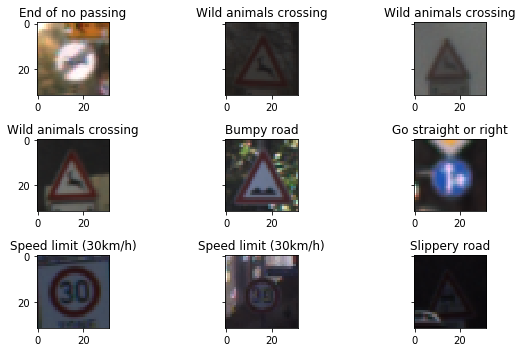

In [10]:
ids = [123,234,456,678,4789,1200,3500,2400,1800]
images = [X_train[id] for id in ids]
labels = [class_to_name[y_train[id]] for id in ids]

def preview_images(imgs, labels, figsize=(8,5)):
    size = int(np.sqrt(len(labels)-1))+1
    f, axes = plt.subplots(size, size, sharey=True, figsize=figsize)
    for x in range(size):
        for y in range(size):
            idx = x*size + y
            axes[x,y].set_title(labels[idx])
            axes[x,y].imshow(imgs[idx])
    plt.tight_layout()

preview_images(images, labels)

Check histogram of classes

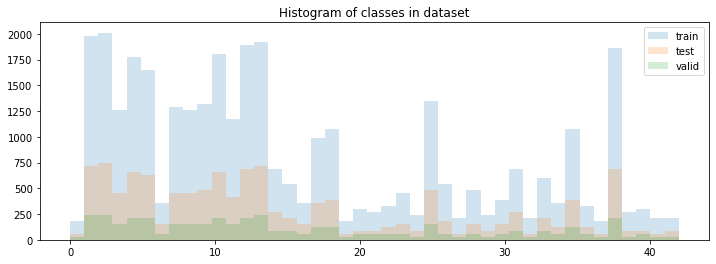

In [11]:
plt.figure(figsize=(12,4))
plt.title("Histogram of classes in dataset")

plt.hist(y_train,bins = n_classes, alpha=0.2, label = 'train')
plt.hist(y_test,bins = n_classes, alpha=0.2, label='test')
plt.hist(y_valid,bins = n_classes, alpha=0.2, label='valid')

plt.legend()
pass

Similarity of distribution of number of items per class in train/test/valid seems to be good

# Preprocessing

Trainig and testing use two separate augmentation pipelines.

* Test augmentation uses only normalization to keep all pixel values in range between -1 and 1.  

* Training augmentation does the same while adding some rangom transformation to make train dataset more generalized and prevent overfitting to given images.

When training many augmentation methods were used:
* **brightness** modification
* **contrast** modification
* **shift** image to prevent overfitting
* **scale** to be able to recognize sing independently to size
* **rotation** and **shear** cause sings can be visible from many different perspectives
* **gaussian noise** to prevent overfitting

In [34]:
augmentation = [
        a.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=20, p=1),
        a.RandomBrightness(0.2,p=1),
        a.RandomContrast(0.2, p=1),
        a.GaussNoise(var_limit=(0,10), p=1),
        a.IAAAffine(shear=20)
    ]

normalization = [a.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)), 
        ToTensor()]

train_augmentation = a.Compose(augmentation+normalization)
test_augmentation = a.Compose(normalization)

Sample images from augmentation:

In [35]:
image_id = 123
augmentation_images = []
augmentation_labels = []

for i in range(25):
    img = X_train[image_id]
    img = a.Compose(augmentation)(image=img)['image']
    augmentation_images.append(img)
    augmentation_labels.append(f"Augmentation {i}")


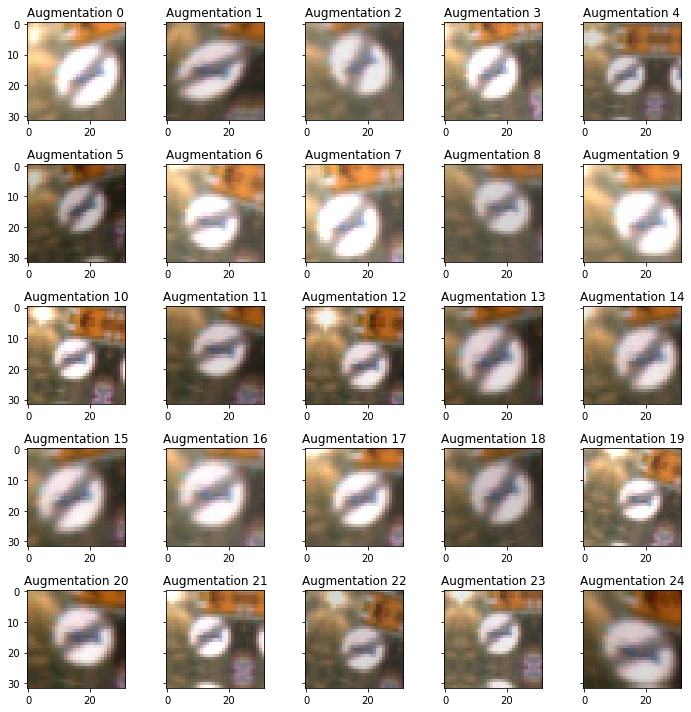

In [36]:
preview_images(augmentation_images, augmentation_labels, figsize=(10,10))

In [37]:
class TrafficSignsDataset(Dataset):
    def __init__(self, features, labels, augmentation):
        self.features = features.copy()
        self.labels  = labels.copy()
        self.augmentation = augmentation
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index, noaug=False):
        img = self.features[index]
        if noaug:
            img = img
        else:
            img = self.augmentation(image=img)['image']
        
        label = int(self.labels[index])
        
        return img, label

In [38]:
train_dataset = TrafficSignsDataset(X_train, y_train, train_augmentation)
test_dataset = TrafficSignsDataset(X_test, y_test, test_augmentation)
valid_dataset = TrafficSignsDataset(X_valid, y_valid, test_augmentation)

Check if datasets work:

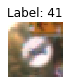

In [39]:
img, label = train_dataset.__getitem__(123, noaug=True)
preview_image(img, f"Label: {label}")

# Model

Used model is simple having (Conv,Pool,Activate, BatchNorm) sequences repeated 4 times.  
After those classification layers (2 Linear separated by Dropout) are used.

There were tests done with state-of-the-art models yt there were inaccurate for that small input as 32x32 where most of them are trained and measured with 224x224 resolution or more. There were two options to choose:
- scale up images
- use simeplier model  
Second option was used to keep training faster.  
Model below weights only about 16MB when trained.  

Model uses activation function from "Mish: A Self Regularized Non-Monotonic Neural Activation Function"  
Link to paper: https://arxiv.org/abs/1908.08681v1  
Implementation for PyTorch aken from https://github.com/lessw2020/mish  

Another regularization technique used in model is Dropout with rate or 0.5

In [40]:
class TSModel(nn.Module):
    def __init__(self, n_classes):
        super(TSModel, self).__init__()
        self.feats = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1, 1),
            nn.MaxPool2d(2, 2),
            Mish(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3,  1, 1),
            Mish(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, 3,  1, 1),
            nn.MaxPool2d(2, 2),
            Mish(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            Mish(),
            nn.BatchNorm2d(128)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128,128)
        self.mish = Mish()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(128, n_classes)

    def forward(self, inputs):
        out = self.feats(inputs)
        out = self.avg_pool(out)
        out = out.view(-1, 128)
        out = self.fc(out)
        out = self.mish(out)
        out = self.dropout(out)
        out = self.classifier(out)

        return out
model=TSModel(n_classes)

Checking if sample outut has proper shape

In [41]:
dummy = torch.zeros((1,3,32,32))
model.eval()
model(dummy).shape

torch.Size([1, 43])

# Training

### Train code

In [42]:
class MetricsAggregator:
    def __init__(self):
        self.epoch_index = -1
        self.loss_history = {}
        self.accuracy_history = {}
    
    def epoch_start(self):
        self.epoch_index += 1
        
    def __add_loss(self, loss):
        if self.epoch_index not in self.loss_history:
            self.loss_history[self.epoch_index] = []
        self.loss_history[self.epoch_index].append(loss)
        
    def __add_acc(self, acc):
        if self.epoch_index not in self.accuracy_history:
            self.accuracy_history[self.epoch_index] = []
        self.accuracy_history[self.epoch_index].append(acc)
        
    def add(self, loss, pred:np.ndarray, gt:np.ndarray):
        self.__add_loss(loss)
        
        pred = np.argmax(pred,axis=1)
        acc = np.sum(pred==gt)/pred.shape[0]
        self.__add_acc(acc)
    
    def get_mean_loss(self, samples=None):
        if samples is None:
            return np.mean(self.loss_history[self.epoch_index])
        return np.mean(self.loss_history[self.epoch_index][-samples:])
    
    def get_mean_acc(self, samples=None):
        if samples is None:
            return np.mean(self.accuracy_history[self.epoch_index])
        return np.mean(self.accuracy_history[self.epoch_index][-samples:])
    
    def get_epochs_losses(self):
        result = []
        for i in range(self.epoch_index+1):
            result.append(np.mean(self.loss_history[i]))
        return result
    
    def get_epochs_acc(self):
        result = []
        for i in range(self.epoch_index+1):
            result.append(np.mean(self.accuracy_history[i]))
        return result

In [43]:
def train(net, loader, aggregator, criterion, device, progress_bar):
    aggregator.epoch_start()
    net.train()
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        aggregator.add(float(loss.item()), outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
        batch_loss = aggregator.get_mean_loss(1)
        total_loss = aggregator.get_mean_loss()
        batch_acc = aggregator.get_mean_acc(1)
        total_acc = aggregator.get_mean_acc()
        progress_bar.update(1)

In [44]:
def test(net, loader, aggregator, criterion, device, return_pred_gt=False):
    net.eval()
    aggregator.epoch_start()
    preds = []
    gts = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            
            if return_pred_gt:
                preds.append(outputs.cpu().detach().numpy())
                gts.append(labels.cpu().detach().numpy())
            
            loss = criterion(outputs, labels)

            aggregator.add(float(loss.item()), outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
            batch_loss = aggregator.get_mean_loss(1)
            total_loss = aggregator.get_mean_loss()
            batch_acc = aggregator.get_mean_acc(1)
            total_acc = aggregator.get_mean_acc()
            
    if return_pred_gt:
        preds = np.vstack(preds)
        gts = np.hstack(gts)
        return preds, gts

### Training execution

In [45]:
batch_size = 256
num_workers = 12
train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=num_workers)
post_train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [46]:
running_train_metrics = MetricsAggregator()
train_metrics = MetricsAggregator()
val_metrics = MetricsAggregator()

In [47]:
best_acc = 0
device = "cuda"
model = model.to(device)

Training uses Focal Loss function described in https://arxiv.org/pdf/1708.02002.pdf  
The implementation was taken from https://github.com/clcarwin/focal_loss_pytorch

In [48]:
epochs = 35
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, 10, gamma=0.1)

In [49]:
with tqdm(desc='Training', total=epochs*len(train_dataloader)) as p:
    for epoch in range(epochs):
        train(model, train_dataloader, running_train_metrics, criterion, device, p)
        test(model, train_dataloader, train_metrics, criterion, device)
        test(model, valid_dataloader, val_metrics, criterion, device)
        
        # Save best model
        isbest=''
        if( val_metrics.get_mean_acc() > best_acc):
            best_acc = val_metrics.get_mean_acc()
            isbest = '(saved)'
            torch.save(model.state_dict(), "best.pth")
            
        print(f"[E{epoch+1}] TrainAcc: {train_metrics.get_mean_acc():0.3f} ValidAcc{isbest}: {val_metrics.get_mean_acc():0.3f}")
                
        scheduler.step()
        p.update(1)

[E1] TrainAcc: 0.244 ValidAcc(saved): 0.214
[E2] TrainAcc: 0.407 ValidAcc(saved): 0.406
[E3] TrainAcc: 0.513 ValidAcc(saved): 0.488
[E4] TrainAcc: 0.631 ValidAcc(saved): 0.619
[E5] TrainAcc: 0.779 ValidAcc(saved): 0.775
[E6] TrainAcc: 0.818 ValidAcc(saved): 0.812
[E7] TrainAcc: 0.881 ValidAcc(saved): 0.881
[E8] TrainAcc: 0.922 ValidAcc(saved): 0.902
[E9] TrainAcc: 0.929 ValidAcc(saved): 0.925
[E10] TrainAcc: 0.948 ValidAcc(saved): 0.945
[E11] TrainAcc: 0.969 ValidAcc(saved): 0.951
[E12] TrainAcc: 0.971 ValidAcc: 0.948
[E13] TrainAcc: 0.973 ValidAcc: 0.950
[E14] TrainAcc: 0.973 ValidAcc: 0.949
[E15] TrainAcc: 0.975 ValidAcc(saved): 0.952
[E16] TrainAcc: 0.972 ValidAcc: 0.949
[E17] TrainAcc: 0.977 ValidAcc(saved): 0.956
[E18] TrainAcc: 0.976 ValidAcc: 0.945
[E19] TrainAcc: 0.979 ValidAcc: 0.947
[E20] TrainAcc: 0.979 ValidAcc: 0.953
[E21] TrainAcc: 0.980 ValidAcc: 0.955
[E22] TrainAcc: 0.980 ValidAcc: 0.951
[E23] TrainAcc: 0.979 ValidAcc: 0.953
[E24] TrainAcc: 0.981 ValidAcc: 0.953
[E25] 

### Post train checks

The metrics are checked once again after training. This time validation set & test set that was never seen before by trainig process.

In [50]:
if os.path.isfile('best.pth'):
    print("Loaded model.")
    model.load_state_dict(torch.load('best.pth'))
    
model = model.to('cuda')

final_val_metrics = MetricsAggregator()
final_test_metrics = MetricsAggregator()

test(model, valid_dataloader, final_val_metrics, criterion, device)
test_preds, test_gts = test(model, test_dataloader, final_test_metrics, criterion, device, return_pred_gt=True)

print(f"Valid loss: {final_val_metrics.get_mean_loss()} Valid acc: {final_val_metrics.get_mean_acc()}")
print(f"Test loss: {final_test_metrics.get_mean_loss()} Test acc: {final_test_metrics.get_mean_acc()}")

Loaded model.
Valid loss: 0.1488018710580137 Valid acc: 0.9563128591954023
Test loss: 0.13985137686133384 Test acc: 0.9580523255813954


# Visualization

### Training/validation loss curves

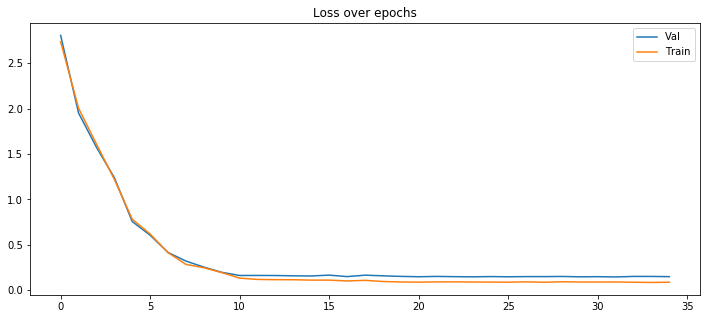

In [51]:
plt.figure(figsize=(12,5))
plt.title("Loss over epochs")
plt.plot(val_metrics.get_epochs_losses(), label='Val')
plt.plot(train_metrics.get_epochs_losses(), label='Train')
plt.legend()

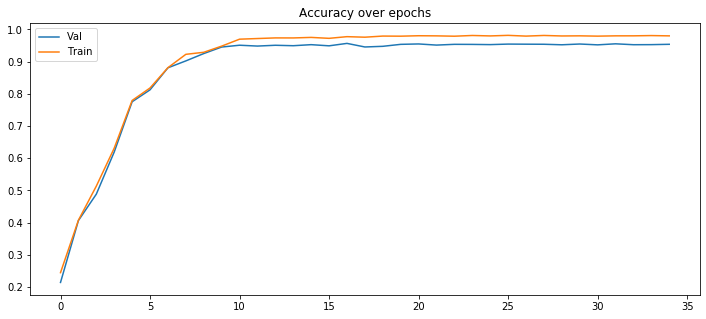

In [52]:
plt.figure(figsize=(12,5))
plt.title("Accuracy over epochs")
plt.plot(val_metrics.get_epochs_acc(), label='Val')
plt.plot(train_metrics.get_epochs_acc(), label='Train')
plt.legend()

### Confusion matrix for classification

Now a confusion matrix is used to visualize misclassifications

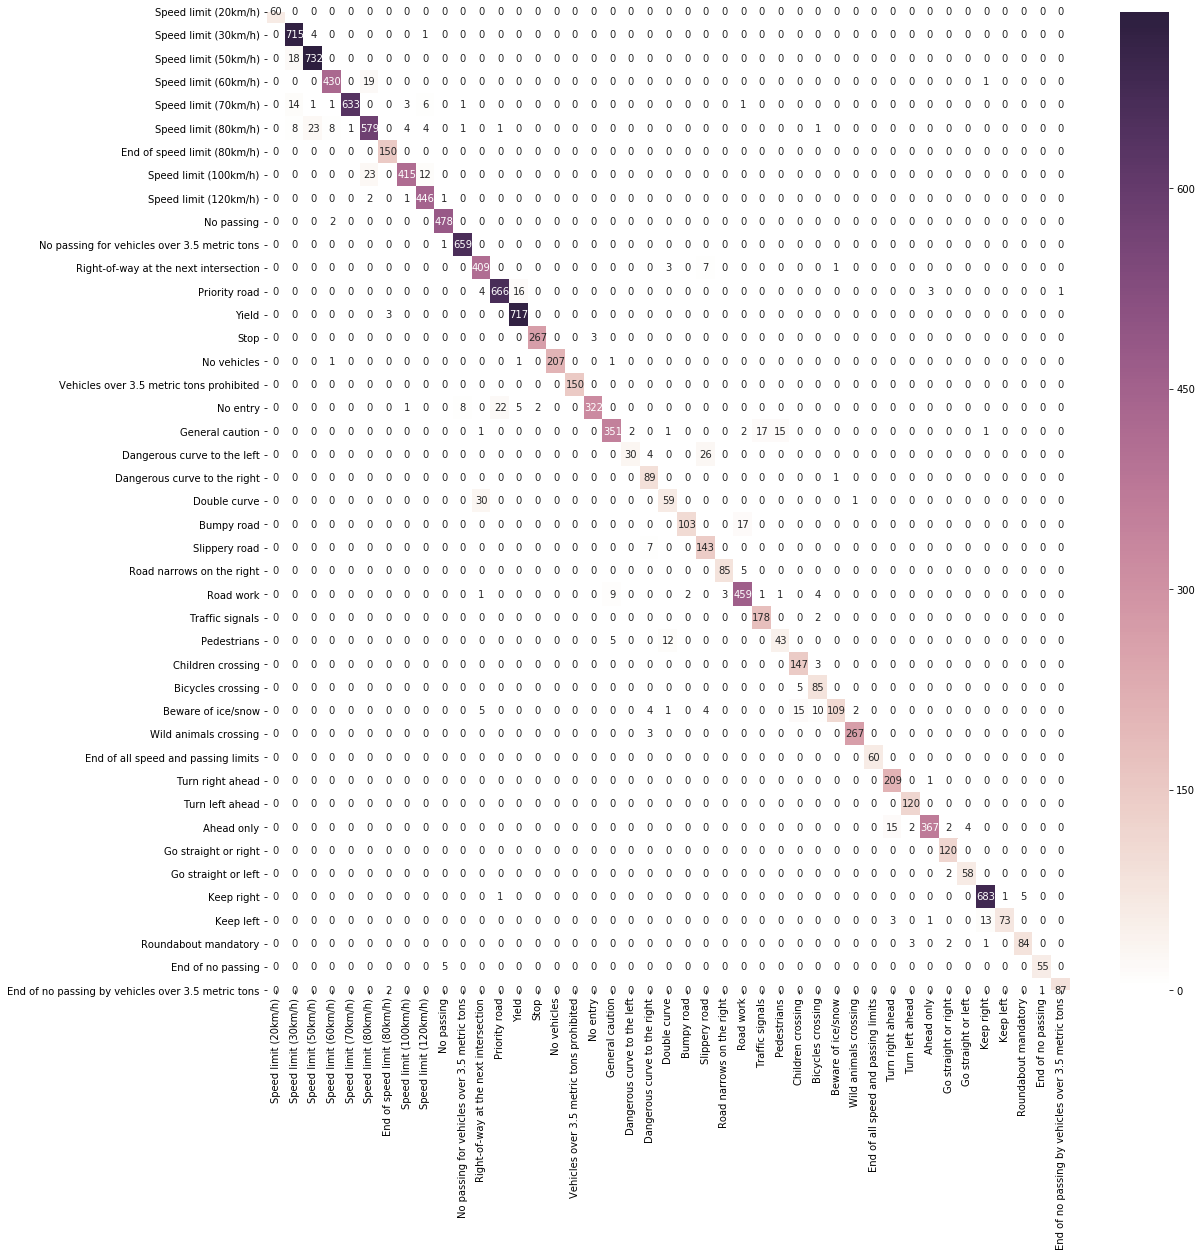

In [53]:
c_matrix = confusion_matrix(test_gts, np.argmax(test_preds, axis=1))
class_names = class_to_name.values()
c_matrix = pd.DataFrame(c_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(18,18))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(c_matrix, annot=True, fmt="d", cmap=cmap)

### Manual check on external sample traffic signs

File './images/test_sign1.jpg'' is classified as: Speed limit (50km/h)


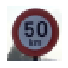

File './images/test_sign2.jpg'' is classified as: Yield


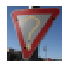

File './images/test_sign3.jpg'' is classified as: Pedestrians


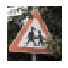

File './images/test_sign4.jpg'' is classified as: No entry


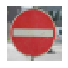

File './images/test_sign5.jpg'' is classified as: Stop


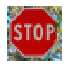

In [59]:
for i in range(1,6,1):
    filename = f'./images/test_sign{i}.jpg'
    img = cv2.imread(filename)[:,:,::-1]
    img = cv2.resize(img,(32,32),interpolation=cv2.INTER_AREA)
      
    # Perform inference
    input = test_augmentation(image=img)['image'].unsqueeze(dim=0).to(device)
    output = model(input).cpu().detach().numpy()
    output = np.argmax(output)
    
    plt.figure(figsize=(1,1))
    print(f"File '{filename}'' is classified as: {class_to_name[output]}")
    plt.axis('off')
    plt.imshow(img)
    plt.show()